# Training the model

## Setup

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import shutil
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Read WSI
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# get the validate percentage of a image
def tissue_pixels_percentage(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percentage = len(tissue_pixels) / float(image.shape[0] * image.shape[0])
    return percentage

In [ ]:
def myImageShow(tumor, mask_tumor):
  plt.figure(figsize=(20,20), dpi=100)
  plt.subplot(131)
  plt.imshow(tumor)
  plt.subplot(132)
  plt.imshow(mask_tumor)
  plt.subplot(133)
  plt.imshow(tumor)
  plt.imshow(mask_tumor, cmap = "jet", alpha = 0.5)
  plt.show()

## Get the images from google drive and split them into training set and validaiton set

In [ ]:
root = '/content/level_2/'
train_dir = os.path.join(root, 'TrainSet')
val_dir = os.path.join(root, 'ValSet')
train_tumor_dir = os.path.join(train_dir, 'tumor')
train_non_tumor_dir = os.path.join(train_dir, 'non_tumor')
val_tumor_dir = os.path.join(val_dir, 'tumor')
val_non_tumor_dir = os.path.join(val_dir, 'non_tumor')
if not os.path.exists(root):
  os.mkdir(root)
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
if not os.path.exists(val_dir):
  os.mkdir(val_dir)
if not os.path.exists(train_tumor_dir):
  os.mkdir(train_tumor_dir)
if not os.path.exists(train_non_tumor_dir):
  os.mkdir(train_non_tumor_dir)
if not os.path.exists(val_tumor_dir):
  os.mkdir(val_tumor_dir)
if not os.path.exists(val_non_tumor_dir):
  os.mkdir(val_non_tumor_dir)

In [ ]:
original_tumor_dir = '/content/gdrive/MyDrive/t2level_2/tumor'
tumor_image_num = len(os.listdir(original_tumor_dir))
print(tumor_image_num)

799


In [ ]:
original_no_tumor_dir = '/content/gdrive/MyDrive/t2level_2/no_tumor'
no_tumor_image_num = 15000
"""
no_tumor_image_num = len(os.listdir(original_no_tumor_dir))
print(no_tumor_image_num)
"""

'\nno_tumor_image_num = len(os.listdir(original_no_tumor_dir))\nprint(no_tumor_image_num)\n'

In [ ]:
import math
train_image_num = math.floor(tumor_image_num * 0.8)
val_image_num = math.floor(tumor_image_num * 0.2)
print(train_image_num, val_image_num)

639 159


### Randomly Get Sample from the set
In the sample process, I try two ways to sample the first one is tumor: non_tumor = 1: 1 and the second one is tumor: non_tumor = 1: 2. From experiment, I I found that 1: 1 sample way have a better result. Therefore, sampling the tumor: non_tumor as 1:1 and split the sample into 2 parts: training set: validation set = 4: 1.

In [ ]:
tumor_sample = random.sample(range(1, tumor_image_num + 1), train_image_num + val_image_num)
no_tumor_sample = random.sample(range(1, no_tumor_image_num + 1), (train_image_num + val_image_num))
#no_tumor_sample = random.sample(range(1, no_tumor_image_num + 1), (train_image_num + val_image_num) * 2)

In [ ]:
print(len(tumor_sample))
print(len(no_tumor_sample))

798
798


In [ ]:
# Copy tumor images to train_tumor_dir
fnames = ['tumor_{}.png'.format(i) for i in tumor_sample[0: train_image_num]]
for fname in fnames:
    src = os.path.join(original_tumor_dir, fname)
    dst = os.path.join(train_tumor_dir, fname)
    shutil.copyfile(src, dst)

# Copy tumor images to val_tumor_dir
fnames = ['tumor_{}.png'.format(i) for i in tumor_sample[train_image_num::]]
for fname in fnames:
    src = os.path.join(original_tumor_dir, fname)
    dst = os.path.join(val_tumor_dir, fname)
    shutil.copyfile(src, dst)

print(len(os.listdir(val_tumor_dir))) 
print(len(os.listdir(train_tumor_dir)))

286
767


In [ ]:
# Copy non tumor images to train_tumor_dir

#fnames = ['no_tumor_{}.jpeg'.format(i) for i in no_tumor_sample[0: train_image_num * 2]]
fnames = ['no_tumor_{}.png'.format(i) for i in no_tumor_sample[0: train_image_num]]
for fname in fnames:
    src = os.path.join(original_no_tumor_dir, fname)
    dst = os.path.join(train_non_tumor_dir, fname)
    shutil.copyfile(src, dst)

# Copy non tumor images to val_tumor_dir
#fnames = ['no_tumor_{}.jpeg'.format(i) for i in no_tumor_sample[train_image_num * 2::]]
fnames = ['no_tumor_{}.png'.format(i) for i in no_tumor_sample[train_image_num::]]
for fname in fnames:
    src = os.path.join(original_no_tumor_dir, fname)
    dst = os.path.join(val_non_tumor_dir, fname)
    shutil.copyfile(src, dst)

print(len(os.listdir(val_non_tumor_dir)))
print(len(os.listdir(train_non_tumor_dir)))

159
639


## Trian the Model with Transfer Learning (Xception)


In [ ]:

base_model = tf.keras.applications.Xception(include_top = False, weights = "imagenet", input_shape = (299, 299, 3))
base_model.trainable = False
model=tf.keras.models.Sequential([   
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6553632   
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 27,415,674
Trainable params: 6,554,194
Non-trainable params: 20,861,480
_________________________________________________________________


### Data Augmentation
The tumor image dataset is small, so using several ways to augment the dataset:
1. Rotation
2. Horizontal Flip and Vertical Flip
3. Random choose adjust brightness (max_delta = 64 / 255), contrast (upper = 0.75), hue (max_delta = 0.04) and saturation (upper = 0.25).

In [ ]:
def MyAugmentationFunction(image):
  choice = random.choice(["brightness", "contrast", "hue", "saturation"])
  if choice == "brightness":
    image = tf.image.random_brightness(image, max_delta = 64 / 255)
  if choice == "contrast":
    image = tf.image.random_contrast(image, lower = 0, upper = 0.75)
  if choice == "hue":
    image = tf.image.random_hue(image, max_delta = 0.04)
  if choice == "saturation":
    image = tf.image.random_saturation(image, lower = 0, upper = 0.25)
  return image

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range = 90,
                                                                vertical_flip = True,
                                                                horizontal_flip = True,
                                                                preprocessing_function = MyAugmentationFunction)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode = 'categorical')

model.compile(optimizer ='RMSprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', tf.keras.metrics.AUC()])

history = model.fit(train_generator, verbose = 1, epochs = 15, validation_data = validation_generator)

Found 1406 images belonging to 2 classes.
Found 445 images belonging to 2 classes.
Epoch 1/15
44/44 [==============================] - 65s 1s/step - loss: 2.4448 - accuracy: 0.7148 - auc_1: 0.7288 - val_loss: 0.3773 - val_accuracy: 0.8382 - val_auc_1: 0.9151
Epoch 2/15
44/44 [==============================] - 63s 1s/step - loss: 0.4875 - accuracy: 0.7838 - auc_1: 0.8702 - val_loss: 0.3133 - val_accuracy: 0.8472 - val_auc_1: 0.9442
Epoch 3/15
44/44 [==============================] - 63s 1s/step - loss: 0.4180 - accuracy: 0.7994 - auc_1: 0.8987 - val_loss: 0.2657 - val_accuracy: 0.8472 - val_auc_1: 0.9531
Epoch 4/15
44/44 [==============================] - 63s 1s/step - loss: 0.3620 - accuracy: 0.8393 - auc_1: 0.9228 - val_loss: 0.3141 - val_accuracy: 0.8090 - val_auc_1: 0.9420
Epoch 5/15
44/44 [==============================] - 63s 1s/step - loss: 0.3339 - accuracy: 0.8385 - auc_1: 0.9315 - val_loss: 0.2443 - val_accuracy: 0.8742 - val_auc_1: 0.9601
Epoch 6/15
44/44 [===================

In [ ]:
train_generator.class_indices

{'non_tumor': 0, 'tumor': 1}

In [ ]:
# Save the model in google drive
model.save("/content/gdrive/MyDrive/MyModels/my_model_level_2_Xception_final_model_1.h5")

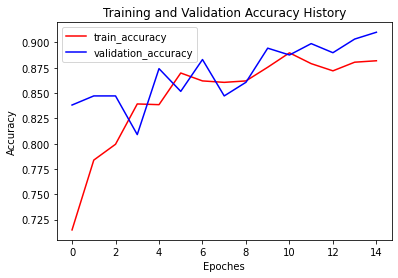

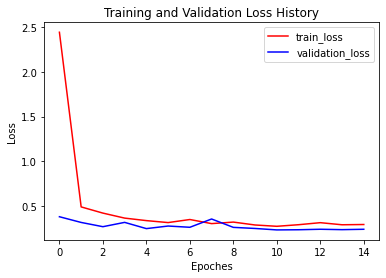

In [ ]:
# Accuracy History
plt.figure(1)
plt.title("Training and Validation Accuracy History")
plt.plot( history.history['accuracy'], color = "red", label = "train_accuracy")
plt.plot( history.history['val_accuracy'], color = "blue", label = "validation_accuracy")
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()

# Loss History
plt.figure(2)
plt.title("Training and Validation Loss History")
plt.plot(history.history['loss'], color = "red", label = "train_loss")
plt.plot(history.history['val_loss'], color = "blue", label = "validation_loss")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()

##Trian the Custom Model

In [ ]:
model=tf.keras.models.Sequential([  
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 146, 146, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 33, 33, 128)      

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range = 90,
                                                                vertical_flip = True,
                                                                horizontal_flip = True,
                                                                preprocessing_function = MyAugmentationFunction)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode = 'categorical')

model.compile(optimizer ='RMSprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', tf.keras.metrics.AUC()])

history = model.fit(train_generator, verbose = 1, epochs = 100, validation_data = validation_generator)

Found 1406 images belonging to 2 classes.
Found 445 images belonging to 2 classes.
Epoch 1/100
44/44 [==============================] - 42s 957ms/step - loss: 0.6952 - accuracy: 0.5284 - auc_6: 0.5248 - val_loss: 0.6399 - val_accuracy: 0.6427 - val_auc_6: 0.7614
Epoch 2/100
44/44 [==============================] - 42s 947ms/step - loss: 0.6964 - accuracy: 0.5882 - auc_6: 0.6030 - val_loss: 0.6193 - val_accuracy: 0.6764 - val_auc_6: 0.7908
Epoch 3/100
44/44 [==============================] - 42s 945ms/step - loss: 0.6607 - accuracy: 0.6266 - auc_6: 0.6512 - val_loss: 0.5960 - val_accuracy: 0.7461 - val_auc_6: 0.8363
Epoch 4/100
44/44 [==============================] - 42s 954ms/step - loss: 0.6635 - accuracy: 0.6444 - auc_6: 0.6734 - val_loss: 0.6076 - val_accuracy: 0.7326 - val_auc_6: 0.8458
Epoch 5/100
44/44 [==============================] - 42s 949ms/step - loss: 0.6412 - accuracy: 0.6550 - auc_6: 0.7013 - val_loss: 0.5650 - val_accuracy: 0.7056 - val_auc_6: 0.8146
Epoch 6/100
44/44

In [ ]:
# Save the model in google drive
model.save("/content/gdrive/MyDrive/MyModels/my_model_level_2_custom_final_model_1.h5")

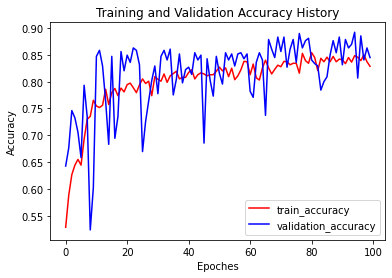

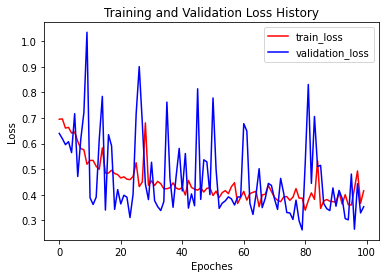

In [ ]:
# Accuracy History
plt.figure(1)
plt.title("Training and Validation Accuracy History")
plt.plot( history.history['accuracy'], color = "red", label = "train_accuracy")
plt.plot( history.history['val_accuracy'], color = "blue", label = "validation_accuracy")
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()

# Loss History
plt.figure(2)
plt.title("Training and Validation Loss History")
plt.plot(history.history['loss'], color = "red", label = "train_loss")
plt.plot(history.history['val_loss'], color = "blue", label = "validation_loss")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()